# MF by ALS, SGD

具体的な説明は下記notebookを参照
- ALS_wt_WR.ipynb
- GD_wt_b.ipynb

In [19]:
import os

import numpy as np
import pandas as pd
from subprocess import call
from sklearn.metrics import mean_squared_error

from numpy.linalg import solve

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

## MovieLens Dataset

In [3]:
file_dir = os.path.join('data', 'ml-100k')
file_path = os.path.join(file_dir, 'u.data')

if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'])
    call(['unzip', 'ml-100k.zip'])
    
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(file_path, sep = '\t', names=names)
print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## sparsity and rating matrix

In [4]:
# create the rating matrix r_{ui}
# remember to subtract the user and item id by 1 since the indices starts from 0
n_users = df['user_id'].unique().shape[0]
n_items = df['item_id'].unique().shape[0]
# initialize
ratings = np.zeros((n_users, n_items))
for row in df.itertuples(index=False): # iterrowよりも高速
    ratings[row.user_id-1, row.item_id-1] = row.rating

# compute the no-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0] # retrun "indices" tha are non-zero
sparsity = (interaction/matrix_size) * 100

print('dimensition: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimensition:  (943, 1682)
sparsity: 6.3%


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

## train test split

In [5]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(np.flatnonzero(ratings[user]), size=10, replace=False)
        
        train[user, test_index] = 0.0 # 学習データからは削除
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    # trainとtestの同じ位置の各要素の積をとり，全て０となるかをチェック
    # testはtrainのうち各ユーザ１０個ずつテストデータをとり，trainはその要素を0とする
    assert np.all(train * test == 0)
    return train, test

In [6]:
train, test = create_train_test(ratings)
# del ratings # save memory
train

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

## MSE

In [16]:
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

## plot MSE

In [22]:
def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

## MF with ALS, SGD

In [14]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

### ALS

In [17]:
MF_ALS = ExplicitMF(train, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_ALS.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 5.468117310002682
Test mse: 9.727773433220648
Iteration: 2
Train mse: 4.223457371564487
Test mse: 8.585519291139951
Iteration: 5
Train mse: 3.986094299745823
Test mse: 8.455329544215695
Iteration: 10
Train mse: 3.95285270900798
Test mse: 8.453504886460431
Iteration: 25
	current iteration: 10
Train mse: 3.940140971447121
Test mse: 8.442521267883004
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 3.938069086713987
Test mse: 8.431292188342166
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 3.9383308361232814
Test mse: 8.419241463820017
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 3.9382677908872403
Test mse: 8.414186157044265


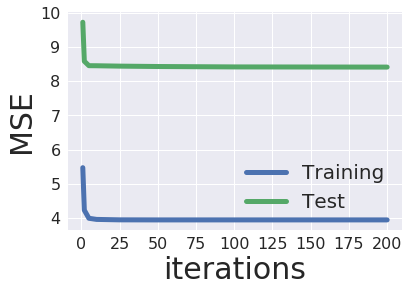

In [21]:
plot_learning_curve(iter_array, MF_ALS)

ALSはすぐ収束するので早い，スケーラビリティが高い  
だが，MSEが後述のSGDと比べかなり高い

しかし，Eye Test（レコメンドされるコンテンツを実際に確認）すると，必ずしもALSが悪いとは限らない

### SGD

In [24]:
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 1.143830583591053
Test mse: 1.170271257356301
Iteration: 2
Train mse: 1.0742642307254764
Test mse: 1.117721082454706
Iteration: 5
Train mse: 0.9780630135744981
Test mse: 1.0374897017623017
Iteration: 10
Train mse: 0.9204536422623553
Test mse: 0.9853606523340922
Iteration: 25
	current iteration: 10
Train mse: 0.8681996026149045
Test mse: 0.9379314415403757
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8398986622394875
Test mse: 0.9205602814056354
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7518400468077027
Test mse: 0.9056523946702862
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.4038588835580364
Test mse: 0.9014333423961077


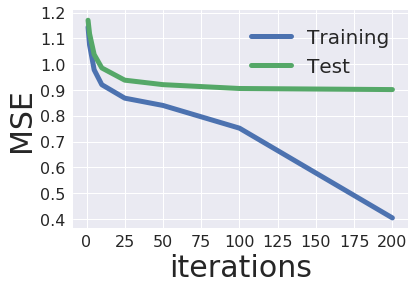

In [25]:
plot_learning_curve(iter_array, MF_SGD)

SGDは最終的な精度は非常に高いが処理に時間がかかる

## summary

SGDはALSと比較し，overfitする傾向にある．特に人気バイアスの影響を受けやすい（人気コンテンツの評価を高くする）  
ところが，最近のNetflixのpaperによると，Eye Testで似ていないように見えるコンテンツ（だが，人気コンテンツ）は，A/Bテストで良い結果を示すことがわかった．A/Bテストはオフライン処理もはるかに重要な結果である．

# Evaluation and tuning

Let’s try to optimize some hyperparameters.  We’ll start with a **grid search** of the **learning rate**.

In [27]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

Rate: 0.0001


KeyboardInterrupt: 

Looks like a learning rate 0.001 was the best value.  
We’ll now complete the hyperparameter optimization with a **grid search** through **regularization terms and latent factors**.  
This takes a while and could easily be parallelized, but that’s beyond the scope of this post. Maybe next post I’ll look into optimizing some of these algorithms.

In [ ]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact inf latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print('New optimal hyperparameters')
            print pd.Series(best_params)

## best parameter

In [ ]:
print('Best regularization: {}'.format(best_params['reg']))
print('Best latent factors: {}'.format(best_params['n_factors']))
print('Best iterations: {}'.format(best_params['n_iter']))

It should be noted that both our best latent factors and best iteration count were at the maximums of their respective grid searches. In hindsight, we should have set the grid search to a wider range. 